In [222]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import math
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

In [223]:
d_model = 512
d_k = 64
d_v = d_k
batch_size = 2
max_seq_length = 9
texts = ["Hello world!", "Hi, how are you today?"]
num_heads = 8
d_ff = 2048
num_encoder_layers = 6
num_decoder_layers = 6

# Input/Output Embedding Layers

<img src="img/embedding_layers.png" height="500px"/>

<img src="img/embedding_softmax.png" height="150px">

In [224]:
class TextEmbedder(nn.Module):
    def __init__(self, d_model: int, verbose: bool = False):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.vocab_size = self.tokenizer.vocab_size
        self.embedding_dim = d_model
        self.embeddings_map = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim)
        self.verbose = verbose

    def forward(self, x: list[str]) -> torch.Tensor:
        tokens = self.tokenizer(x, padding=True, truncation=True, return_tensors="pt")
        
        tokens_ids = tokens["input_ids"]
        
        embeddings = self.embeddings_map(tokens_ids) * math.sqrt(self.embedding_dim)

        if self.verbose:
            print(f"tokens_ids shape: {tokens_ids.shape}\ntoken_ids: {tokens_ids}")
            print(f"embeddings shape : {embeddings.shape}")
        
        return embeddings

    def get_embedding_weights(self) -> torch.Tensor:
        return self.embeddings_map.weight

## Smoke Test

In [225]:
text_embedder = TextEmbedder(d_model=d_model, verbose=True)
embeddings = text_embedder(texts)

tokens_ids shape: torch.Size([2, 9])
token_ids: tensor([[ 101, 7592, 2088,  999,  102,    0,    0,    0,    0],
        [ 101, 7632, 1010, 2129, 2024, 2017, 2651, 1029,  102]])
embeddings shape : torch.Size([2, 9, 512])


# Positional Encoding

<img src="img/positional_encoding_layers.png" height="500px"/>

<img src="img/positional_encoding.png" height="150px">

In [248]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_seq_length: int):
        super().__init__()
        self.d_model = d_model
        self.max_seq_length = max_seq_length
        self.register_buffer('positional_encoding', self.compute_sin_cos_pos_encoding_matrix())
    
    def compute_sin_cos_pos_encoding_matrix(self):
        self.sequence_positions = torch.arange(0, self.max_seq_length).unsqueeze(1)
        self.even_embed_indexes = torch.arange(0, self.d_model, 2)
        self.odd_embed_indexes = torch.arange(1, self.d_model, 2)

        positional_encoding_matrix = torch.zeros((1, self.max_seq_length, self.d_model))

        division_term = 10_000**(self.even_embed_indexes/self.d_model)

        scaled_sequence_position = self.sequence_positions / division_term

        positional_encoding_matrix[0, :, self.even_embed_indexes] = torch.sin(scaled_sequence_position)
        positional_encoding_matrix[0, :, self.odd_embed_indexes] = torch.cos(scaled_sequence_position)

        return positional_encoding_matrix

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[1] <= self.max_seq_length, f"Max sequence length is {self.max_seq_length} but input has sequence length of {x.shape[1]}!"
        return x + self.positional_encoding

## Smoke Test

In [227]:
pe = PositionalEncoding(d_model=d_model, max_seq_length=max_seq_length)

print(f"Embedding (token 0, seq pos 0) before positional encoding : {embeddings[0, 0, 0]}")

position_aware_embeddings = pe(embeddings)

print(f"Embedding (token 0, seq pos 0) after positional encoding : {position_aware_embeddings[0, 0, 0]}")

print(f"position_aware_embeddings shape: {position_aware_embeddings.shape}")

Embedding (token 0, seq pos 0) before positional encoding : 5.509275436401367
x.shape: torch.Size([2, 9, 512])
x.shape: torch.Size([1, 9, 512])
Embedding (token 0, seq pos 0) after positional encoding : 5.509275436401367
position_aware_embeddings shape: torch.Size([2, 9, 512])


## Positional Encoding Visualization

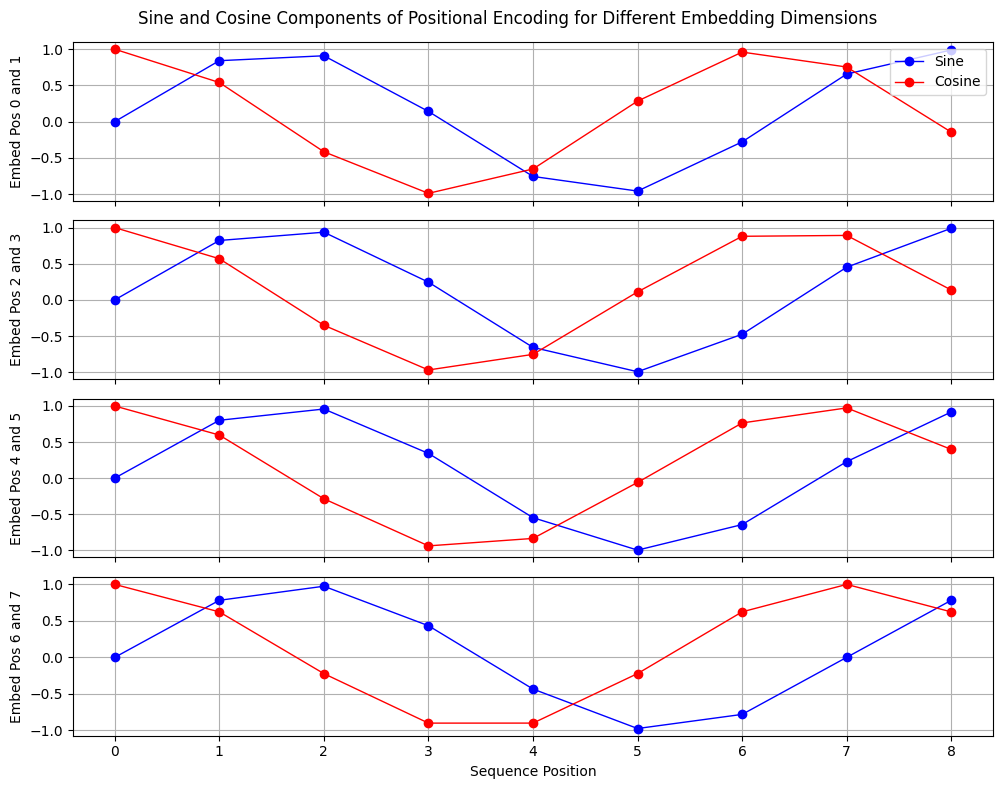

In [228]:
num_dimensions_to_plot = 4

fig, axs = plt.subplots(num_dimensions_to_plot, 1, figsize=(10, 8), sharex=True)

x = pe.sequence_positions.squeeze()

for idx, i in enumerate(range(0, num_dimensions_to_plot)):  
    y_sin = pe.positional_encoding[0, :, i * 2]  
    y_cos = pe.positional_encoding[0, :, i * 2 + 1]  
    
    axs[idx].plot(x, y_sin, marker='o', linewidth=1, color='b')
    axs[idx].plot(x, y_cos, marker='o', linewidth=1, color='r')
    
    axs[idx].set_ylabel(f"Embed Pos {i * 2} and {i * 2 + 1}")
    axs[idx].grid(True)

    if idx == 0:
        axs[idx].legend(['Sine', 'Cosine'], loc='upper right')

axs[-1].set_xlabel('Sequence Position')

fig.suptitle('Sine and Cosine Components of Positional Encoding for Different Embedding Dimensions')

plt.tight_layout()

plt.show()

# Scaled Dot-Product Attention

<img src="img/scaled_dot_product_attention.png" height="300px">

<img src="img/scaled_dot_product_attention_math.png" height="100px"/>

In [229]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k: int):
        super().__init__()
        self.d_k = d_k

    def forward(
        self,
        queries: torch.Tensor,
        keys: torch.Tensor,
        values: torch.Tensor,
        mask: torch.Tensor = None
    ) -> torch.Tensor:
        """
        Args:
            queries (torch.Tensor): (batch_size, num_heads, seq_length, head_dim)
            keys (torch.Tensor): (batch_size, num_heads, seq_length, head_dim)
            values (torch.Tensor): (batch_size, num_heads, seq_length, head_dim)
            mask (torch.Tensor, optional): (batch_size, num_heads, seq_length, seq_length)

        Returns: (batch_size, num_heads, seq_length, head_dim)
        """
        attention_scores_logits = torch.matmul(
            queries, keys.transpose(-2, -1)
        ) / math.sqrt(self.d_k)  # Shape: (batch_size, num_heads, seq_length, seq_length)

        if mask is not None:
            attention_scores_logits = attention_scores_logits.masked_fill(mask == 0, -float('inf'))

        attention_probs = torch.softmax(attention_scores_logits, dim=-1)

        output = torch.matmul(attention_probs, values)  # Shape: (batch_size, num_heads, seq_length, head_dim)

        return output

Note : I adapted my ScaledDotProductAttention to receive num_heads inputs so that we can compute the heads in parallel.  
Alternative implementation (slower) could instead receive (batch, seq_len, head_dim) and use `torch.bmm` instead of `torch.matmul`.

## Smoke Test

### No Mask

In [230]:
scaled_dot_product_attention = ScaledDotProductAttention(d_k=d_k)

queries = torch.randn(batch_size, num_heads, max_seq_length, d_k)

keys = torch.randn(batch_size, num_heads, max_seq_length, d_k)

values = torch.randn(batch_size, num_heads, max_seq_length, d_v)

print(f"queries.shape: {queries.shape}")
print(f"keys.shape: {keys.shape}")
print(f"values.shape: {values.shape}")

print(f"Scaled dot product attention shape : {scaled_dot_product_attention(queries, keys, values).shape}")

queries.shape: torch.Size([2, 8, 9, 64])
keys.shape: torch.Size([2, 8, 9, 64])
values.shape: torch.Size([2, 8, 9, 64])
Scaled dot product attention shape : torch.Size([2, 8, 9, 64])


### With Mask

In [231]:
mask = torch.tril(torch.ones((max_seq_length, max_seq_length), dtype=torch.bool))
mask = mask.unsqueeze(0).unsqueeze(1).expand(batch_size, num_heads, max_seq_length, max_seq_length)

print(f"Mask for testing purposes (batch size = {batch_size}):")
print(f"Shape: {mask.shape}")
print(mask)

print(f"MASKED scaled dot product attention shape : {scaled_dot_product_attention(queries, keys, values, mask).shape}")

Mask for testing purposes (batch size = 2):
Shape: torch.Size([2, 8, 9, 9])
tensor([[[[ True, False, False,  ..., False, False, False],
          [ True,  True, False,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          ...,
          [ True,  True,  True,  ...,  True, False, False],
          [ True,  True,  True,  ...,  True,  True, False],
          [ True,  True,  True,  ...,  True,  True,  True]],

         [[ True, False, False,  ..., False, False, False],
          [ True,  True, False,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          ...,
          [ True,  True,  True,  ...,  True, False, False],
          [ True,  True,  True,  ...,  True,  True, False],
          [ True,  True,  True,  ...,  True,  True,  True]],

         [[ True, False, False,  ..., False, False, False],
          [ True,  True, False,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False

# Multi-Head Attention

<img src="img/multi_head_attention_layers.png" height="500px"/> 
<br/>
<img src="img/multi_head_attention.png" height="300px"/>  
<br/>
<img src="img/multi_head_attention_math.png" height="100px"/>

In [232]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int):
        super().__init__()

        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads # Note that head_dim = d_k = d_v just like in the original paper.

        self.queries_projections = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.keys_projections = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.values_projections = nn.Linear(in_features=d_model, out_features=d_model, bias=False)

        self.attention = ScaledDotProductAttention(d_k=self.head_dim)

        self.output_projections = nn.Linear(in_features=num_heads*self.head_dim, out_features=d_model, bias=False)
    
    def forward(self, queries: torch.Tensor, keys: torch.Tensor, values: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, d_model_query = queries.shape
        batch_size, seq_len, d_model_key = keys.shape
        batch_size, seq_len, d_model_value = values.shape

        assert self.d_model == d_model_query == d_model_key == d_model_value, f"Mismatch in expected d_model!"

        q = self.queries_projections(queries)  # shape: (batch_size, seq_len, num_heads * head_dim)
        k = self.keys_projections(keys)      # shape: (batch_size, seq_len, num_heads * head_dim)
        v = self.values_projections(values)  # shape: (batch_size, seq_len, num_heads * head_dim)

        q = q.reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # shape: (batch_size, num_heads, seq_len, head_dim)
        k = k.reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)    # shape: (batch_size, num_heads, seq_len, head_dim)
        v = v.reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # shape: (batch_size, num_heads, seq_len, head_dim)

        heads = self.attention(queries=q, keys=k, values=v, mask=mask)

        concatenated_heads = heads.permute(0, 2, 1, 3).reshape(batch_size, seq_len, -1)

        output = self.output_projections(concatenated_heads)

        return output

## Smoke Test

### No Mask

In [233]:
mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

x = torch.randn((batch_size, max_seq_length, d_model))

print(f"Input shape: {x.shape}")
print(f"MultiHeadAttention output shape: {mha(queries=x, keys=x, values=x, mask=None).shape}")

Input shape: torch.Size([2, 9, 512])
MultiHeadAttention output shape: torch.Size([2, 9, 512])


### With Mask

In [234]:
print(f"Input shape: {x.shape}")
print(f"MASKED MultiHeadAttention output shape: {mha(queries=x, keys=x, values=x, mask=mask).shape}")

Input shape: torch.Size([2, 9, 512])
MASKED MultiHeadAttention output shape: torch.Size([2, 9, 512])


# Feed Forward

<img src="img/feed_forward_layers.png" height="500px"/>  
<br/>
<img src="img/feed_forward.png" height="250px"/>

In [235]:
class PositionWiseFeedForwardNetwork(nn.Module):
    def __init__(self, d_model: int, d_ff: int):
        super().__init__()
        self.fc1 = nn.Linear(in_features=d_model, out_features=d_ff, bias=True)
        self.fc2 = nn.Linear(in_features=d_ff, out_features=d_model, bias=True)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Smoke Test

In [236]:
feed_forward = PositionWiseFeedForwardNetwork(d_model=d_model, d_ff=d_ff)

x = torch.randn(batch_size, max_seq_length, d_model)

print(f"x.shape: {x.shape}")
print(f"position wise feed forward network output shape: {feed_forward(x).shape}")

x.shape: torch.Size([2, 9, 512])
position wise feed forward network output shape: torch.Size([2, 9, 512])


# Encoder Layer

<img src="img/encoder_layer.png" height="500px">

<img src="img/encoder.png" height="150px"/>

In [237]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int):
        super().__init__()
        self.multi_head_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm_1 = nn.LayerNorm(normalized_shape=d_model)
        self.feed_forward = PositionWiseFeedForwardNetwork(d_model=d_model, d_ff=d_ff)
        self.layer_norm_2 = nn.LayerNorm(normalized_shape=d_model)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer_norm_1(x + self.multi_head_attention(queries=x, keys=x, values=x, mask=None))
        x = self.layer_norm_2(x + self.feed_forward(x))
        return x

## Smoke Test

In [238]:
encoder_layer = TransformerEncoderLayer(d_model=d_model, num_heads=num_heads, d_ff=d_ff)

x = torch.randn(batch_size, max_seq_length, d_model)

print(f"Input X: {x.shape}")
print(F"Transformer Encoder Layer output : {encoder_layer(x).shape}")

Input X: torch.Size([2, 9, 512])
Transformer Encoder Layer output : torch.Size([2, 9, 512])


# Encoder

<img src="img/encoder_layers.png" height="500px"/>  

In [239]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers: int, num_heads: int, d_model: int, d_ff: int):
        super().__init__()
        self.layers = nn.Sequential(*[TransformerEncoderLayer(d_model=d_model, num_heads=num_heads, d_ff=d_ff) for _ in range(num_layers)])
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layers(x)
        return x

## Smoke Test

In [240]:
transformer_encoder = TransformerEncoder(num_layers=num_encoder_layers, num_heads=num_heads, d_model=d_model, d_ff=d_ff)
x = torch.randn(batch_size, max_seq_length, d_model)
print(f"Input X: {x.shape}")
print(f"Transformer encoder output shape: {transformer_encoder(x).shape}")

Input X: torch.Size([2, 9, 512])
Transformer encoder output shape: torch.Size([2, 9, 512])


# Decoder Layer

<img src="img/decoder_layer.png" height="500px"/>  

In [241]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model: int, num_heads: int):
        super().__init__()
        self.masked_multi_head_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm_1 = nn.LayerNorm(normalized_shape=d_model)

        self.multi_head_cross_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm_2 = nn.LayerNorm(normalized_shape=d_model)

        self.feed_forward = PositionWiseFeedForwardNetwork(d_model=d_model, d_ff=d_ff)
        self.layer_norm_3 = nn.LayerNorm(normalized_shape=d_model)
    
    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, _ = x.shape

        mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool))
        mask = mask.unsqueeze(0).unsqueeze(1).expand(batch_size, num_heads, max_seq_length, max_seq_length)
        x = self.layer_norm_1(x + self.masked_multi_head_attention(queries=x, keys=x, values=x, mask=mask))

        x = self.layer_norm_2(x + self.multi_head_cross_attention(queries=x, keys=encoder_output, values=encoder_output, mask=None))

        x = self.layer_norm_3(x + self.feed_forward(x))

        return x

## Smoke Test

In [242]:
decoder_layer = TransformerDecoderLayer(d_model=d_model, num_heads=num_heads)

x = torch.randn((batch_size, max_seq_length, d_model))
encoder_output = torch.randn((batch_size, max_seq_length, d_model))

print(f"x shape: {x.shape}")
print(f"encoder output shape: {encoder_output.shape}")
print(f"decoder layer output shape: {decoder_layer(x=x, encoder_output=encoder_output).shape}")

x shape: torch.Size([2, 9, 512])
encoder output shape: torch.Size([2, 9, 512])
decoder layer output shape: torch.Size([2, 9, 512])


# Decoder

<img src="img/decoder_layers.png" height="500px"/>

In [243]:
class TransformerDecoder(nn.Module):
    def __init__(self, num_layers: int, d_model: int, num_heads: int):
        super().__init__()
        self.layers = nn.ModuleList([TransformerDecoderLayer(d_model=d_model, num_heads=num_heads) for _ in range(num_layers)])

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x=x, encoder_output=encoder_output)
        return x

## Smoke Test

In [244]:
decoder = TransformerDecoder(num_layers=num_decoder_layers, d_model=d_model, num_heads=num_heads)

x = torch.randn((batch_size, max_seq_length, d_model))
encoder_output = torch.randn((batch_size, max_seq_length, d_model))

print(f"x shape: {x.shape}")
print(f"encoder output shape: {encoder_output.shape}")
print(f"decoder output shape: {decoder(x=x, encoder_output=encoder_output).shape}")

x shape: torch.Size([2, 9, 512])
encoder output shape: torch.Size([2, 9, 512])
decoder output shape: torch.Size([2, 9, 512])


# Transformer (Putting everything together!)

<img src="img/transfomer_end_to_end.png" height="500px"/>

In [251]:
class Transformer(nn.Module):
    def __init__(self, d_model: int, d_ff: int, max_seq_length: int, num_encoder_layers: int, num_encoder_heads: int, num_decoder_layers: int, num_decoder_heads: int):
        super().__init__()
        self.input_output_embedder = TextEmbedder(d_model=d_model)
        self.positional_encoding = PositionalEncoding(d_model=d_model, max_seq_length=max_seq_length)

        self.encoder = TransformerEncoder(num_layers=num_encoder_layers, num_heads=num_encoder_heads, d_model=d_model, d_ff=d_ff)

        shared_embedding_weights = self.input_output_embedder.get_embedding_weights().T
        self.output_projection = nn.Linear(in_features=d_model, out_features=self.input_output_embedder.vocab_size, bias=False)
        self.output_projection.weight = nn.Parameter(shared_embedding_weights)

        self.decoder = TransformerDecoder(num_layers=num_decoder_layers, d_model=d_model, num_heads=num_decoder_heads)
    
    def forward(self, x: list[str], target_sequence: list[str]) -> torch.Tensor:
        input_embeddings = self.input_output_embedder(x)
        input_embeddings = self.positional_encoding(input_embeddings)

        encoder_output = self.encoder(input_embeddings)

        decoder_input = self.input_output_embedder(["<SOS>"])
        decoder_input = self.positional_encoding(decoder_input)

        decoded_logits = []

        for i in range(len(target_sequence)):
            decoder_output = self.decoder(x=decoder_input, encoder_output=encoder_output)
            
            vocab_logits = self.output_projection(decoder_output)

            decoded_logits.append(vocab_logits)

            predicted_token = vocab_logits.argmax(dim=-1)

            print(f"predicted_token: {predicted_token}")

            predicted_token_embed = self.input_output_embedder([self.input_output_embedder.tokenizer.decode(predicted_token.squeeze())])
            predicted_token_embed = self.positional_encoding(predicted_token_embed)

            decoder_input = predicted_token_embed

        decoded_logits = torch.cat(decoded_logits, dim=1) # Shape: (batch_size, seq_length, vocab_size)

        return decoded_logits

## Smoke Test

In [252]:

transformer_model = Transformer(
    d_model=d_model,
    d_ff=d_ff,
    max_seq_length=max_seq_length,
    num_encoder_layers=num_encoder_layers,
    num_encoder_heads=num_heads,
    num_decoder_layers=num_decoder_layers,
    num_decoder_heads=num_heads
)


output_logits = transformer_model(texts, texts)

print(f"Output logits shape: {output_logits.shape}")


RuntimeError: The size of tensor a (6) must match the size of tensor b (9) at non-singleton dimension 1